# Bayesian Model Fitting

- *Jake VanderPlas*
- *ESAC statistics workshop, Oct 27-31 2014*
- *Source available on [github](http://github.com/jakevdp/ESAC-stats-2014)

## Preliminaries

Again, we'll start with some boilerplate imports and setup

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# fig_code is in the repository linked above
import fig_code

# use seaborn plotting defaults
# If this causes an error, you can comment it out.
import seaborn as sns
sns.set()

## Exploring Probability

Bayesian approaches to model fitting are all about probability. Previously we looked at probability within the likelihood; for a single measured number, we have a probability density that looks like this:

$$
p(y~|~I)
$$

Here $y$ is the value that we observe, and $I$ is whatever information is out there that helps us specify this.
This expression should be read *the probability density of $y$ given $I$*.

Often statistics courses will go to great lengths to distinguish discrete probabilities from continuous probability densities; here we're going to ignore the discrete case and just look at the continuous case. A probability density must satisfy the following:

$$
\int_{-\infty}^\infty p(y~|~I)dy = 1
$$

That is, the probability density is normalized.

**Question 1: what are the units of $p(y~|~I)$?**

**Question 2: what does $\int p(y~|~I)dI$ mean?**

*Answer 1: units of $p(y~|~I)$ are inverse of the units of $y$! So, for example, if $y$ is a distance, $p(y~|~I)$ has units 1/distance*
    
*Answer 2: it's meaningless! You should never do that integral!*

### The Units of Probability Density

This is an important thing to remember: the units of a probability density are the inverse of the units of the quantity in question. Keeping this in mind will help you recognize all sorts of common mistakes in computations of probability.

### Joint Probabilities

As we saw in the frequentist section, we can write *joint* probability densities for multiple variables. This is written as:

$$
p(x, y~|~I)
$$

This should be read "the probability density of $x$ and $y$ given $I$".
In analogy to above, it must satisfy the equation

$$
\iint p(x, y~|~I) dxdy = 1
$$

Take a moment and think about this: what are the units of this joint probability?

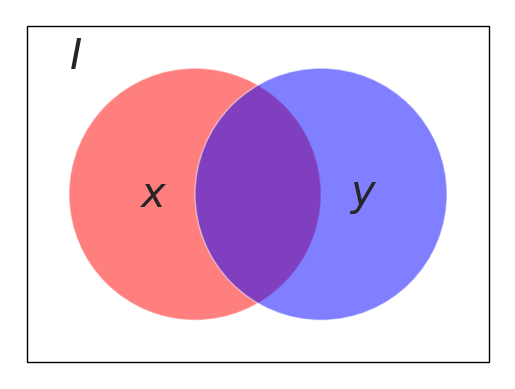

In [2]:
fig_code.plot_venn_diagram()

One nice way to think about joint probabilities is in terms of a Venn Diagram. Areas in the Venn diagram are proportional to probabilities, and here we're just looking at the part of parameter space where $\theta$ holds.

- When we write $p(x~|~I)$, this is akin to measuring the area of the $x$ region compared to the area of the $I$ region.
- When we write $p(x,y~|~I)$, this is akin to measuring the area of the intersection of $x$ and $y$ compared to the area of the $I$ region.

**Question: what would $p(x~|~y,I)$ mean?**

If we write something like $p(x~|~y,I)$, this is known as the *conditional* probability of $x$ given $y$ (and $I$).

**Question: Looking at the Venn Diagram, how could you express this conditional probability in terms of the joint probability?**

### Deriving Bayes' Rule

One of the fundamental rules of conditional probability is this:

$$
p(x~|~y,I) \equiv \frac{p(x, y~|~I)}{p(y~|~I)}
$$

Or, rewriting this, we have the expression:

$$
p(x, y~|~I) = p(x~|~y,I) p(y~|~I)
$$

Of course, this is symmetric so we could also write:

$$
p(x, y~|~I) = p(y~|~x,I) p(x~|~I)
$$

Putting these last two together, we see

$$
p(x~|~y,I) p(y~|~I) = p(y~|~x,I) p(x~|~I)
$$

Which, rearranged slightly, looks like this

$$
p(x~|~y,I) = \frac{p(y~|~x,I) p(x~|~I)}{p(y~|~I)}
$$

This little result is known as *Bayes' Rule* or *Bayes' Theorem*, after the reverend Thomas Bayes. We'll come back to this in a bit, but first we have to get a bit philosophical.

### What Is a Probability?

Above we've been happily exploring the mathematical characteristics of probability; but we haven't stopped to ask **what** the probability is measuring. For example, when I say "the probability that this coin will land heads is 50%", what claim am I actually making?

A full answer to this would probably require a semester philosophy class, but history has distilled for us two camps of thought on this question:

- **frequentist** or **classical** statistics would say that the probability is a statement about limiting frequencies in repeated trials: in the limit of many coin flips, 50% of the results will be heads.

- **Bayesian** statistics extends this notion of probability to include **degrees of belief**. So, even absent a large number of (real or imaginary) trials, we could say that the 50% probability indicates our certainty of a single result: given what we know about the coin, we are 50% certain that the flip will land heads.

But enough of this philosophy stuff... how does this relate to model fitting?

## Bayes' Rule & Model Fitting

Let's re-write Bayes' rule here, but we'll replace $x$ with $\theta$, representing our model parameters (e.g. $\theta = [m, b]$, the slope and intercept of the line), and we'll replace $y$ with $D$, representing our observed data (e.g. $D = \{x_i, y_i, \sigma_i\}$):

$$
p(\theta~|~D,I) = \frac{p(D~|~\theta,I)~p(\theta~|~I)}{p(D~|~I)}
$$

This shows us a formula for computing the *probability (i.e. degree of belief) of our model parameters given the observed data*.

When we write Bayes' rule this way, we're all of a sudden doing something controversial: can you see where this controversy lies?

*Answer: two controversial points:*

1. We have a probability distribution over model parameters. A frequentist would say this is meaningless!
2. The answer depends on the expression $p(\theta~|~I)$. This is the probability of the model parameters **without any data**: how are we supposed to know that?

Nevertheless, applying Bayes' rule in this manner gives us a means of quantifying our **knowledge of the parameters $\theta$ given observed data**

### Four Terms in Bayes' Rule

We have four terms in the above expression, and we need to make sure we understand them:

#### $p(\theta~|~D,I)$: the *posterior*
This contains all the information about the answer we're interested in.

#### $p(D~|~\theta,I)$: the *likelihood*
notice that it's identical to the frequentist likelihood that we discussed in the earlier section.

#### $p(\theta~|~I)$: the *Prior*
This contains any information we know about the model before updating it with our data $D$

#### $p(D~|~I)$: the *Evidence*
This amounts basically to a normalization term: notice that $p(D~|~I) = \int p(D~|~\theta,I)p(\theta~|~I)d\theta$. You (almost) never need to actually calulate this.

## Bayesian Straight Line Fit

After all this theoretical development, it's time to apply this to data!
Just as a reminder, here's our dataset, $D = \{x_i, y_i, \sigma_i\}$:

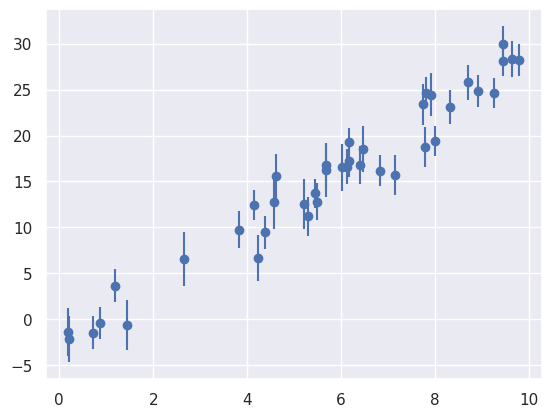

In [3]:
from fig_code import linear_data_sample
x, y, dy = linear_data_sample()
plt.errorbar(x, y, dy, fmt='o');

And our model is $y_M(x; \theta) = mx + b$ where $\theta = [m, b]$.

We write Bayes' theorem as follows:

$$
p(\theta~|~D) \propto p(D~|~\theta)~p(\theta)
$$

And we'll maximize this expression with respect to $\theta$. Notice that the only difference between this and the maximum likelihood approach is that we multiply the likelihood by a prior before maximization. We **have** to specify this prior... so what should we choose?

**Question: what are some potential prior choices?**

- A *Flat prior*, i.e. $p(\theta) \propto 1$ over some wide range.
- A *Noninformative prior*, perhaps based on dimensionality, symmetry, or entropy arguments
- An *Empirical prior*, based on previous unrelated data which constrains this model.

But note that in the presence of data which strongly constrains the model, the effect of these priors is extremely small.

### Marginalization
You might be wondering what the point of all this is. Now rather than maximizing the likelihood, we're maximizing the likelihood after multiplying it by a function (the prior) which is seeminly arbitrarily chosen. What's the point of it?

Well, the posterior actually has some nice properties. For example, it is possible to integrate over some (but not all) of the parameters in the posterior to find *marginalized* posteriors. This lets us ignore some parts of the fit, usually known as *nuisance parameters*.

For example, our posterior here is

$$
p(m,b~|~D)
$$

Say we don't care about the intercept $b$, but it is required because of some unknown bias in the measurement. We simply marginalize it out, and compute

$$
p(m~|~D) = \int_{-\infty}^\infty p(m,b~|~D)~{\rm d}b
$$

This marginalized posterior only gives us what we're interested in: the posterior probability of the slope given our data. But now this is becoming a hard computation. Analytically integrating our likelihood over $b$ (even with a simple prior) is hard! For this reason, Bayesian computations usually proceed using **sampling** methods such as *Markov Chain Monte Carlo*

## Bayesian Model Fitting via Sampling

We'll not go through the theoretical details of sampling here, but for now just say that a sampling approach bases results on **drawing samples from the posterior**. Once these samples are drawn, we can use the characteristics of our sample to solve our problem.

We'll use the excellend [emcee](http://dan.iel.fm/emcee/) package to do this. To use emcee, we'll need to define a function which computes the log-posterior:

In [4]:
def model(theta, x):
    return theta[0] * x + theta[1]

def log_prior(theta):
    # Use a flat prior for now
    return 0

def log_likelihood(theta, x, y, dy):
    y_model = model(theta, x)
    return -0.5 * np.sum(np.log(2 * np.pi * dy ** 2) + (y - y_model) ** 2 / (2 * dy) ** 2)

def log_posterior(theta, x, y, dy):
    return log_prior(theta) + log_likelihood(theta, x, y, dy)

In [5]:
# run this to install emcee:
# !pip install emcee

In [6]:
import emcee

np.random.seed(0)

ndim = 2  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# we'll start at random locations between 0 and 2000
starting_guesses = np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, dy])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)

Now we have a sample of points drawn from the posterior! Let's plot these using Dan Foreman-Mackey's ``triangle`` package:

In [7]:
# run this to install triangle:
# !pip install triangle_plot corner

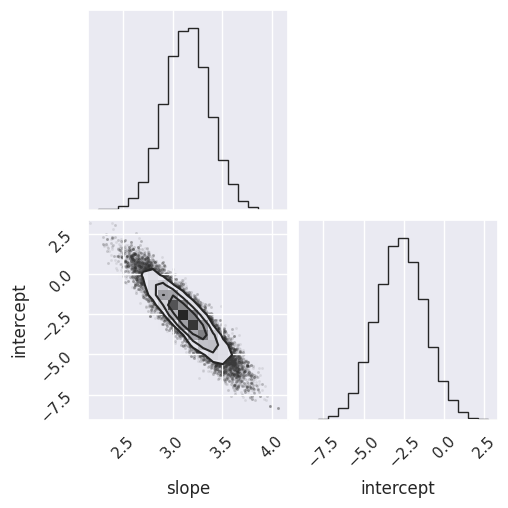

In [8]:
# import triangle, corner
# triangle.corner(sample, labels=['slope', 'intercept']);
import corner
corner.corner(sample, labels=['slope', 'intercept']);

We see that the slope and intercept are roughly Gaussian-distributed, and are negatively correlated.
If we want to see the "best-fit" value, we can choose the maximum of the posterior to find the for *Maximum a Posteriori* fit, which in the Gaussian case will be very close to the mean of the samples:

In [9]:
theta_MAP = sample.mean(0)
print(theta_MAP)

[ 3.14347795 -2.71112906]


Let's plot this result over the data:

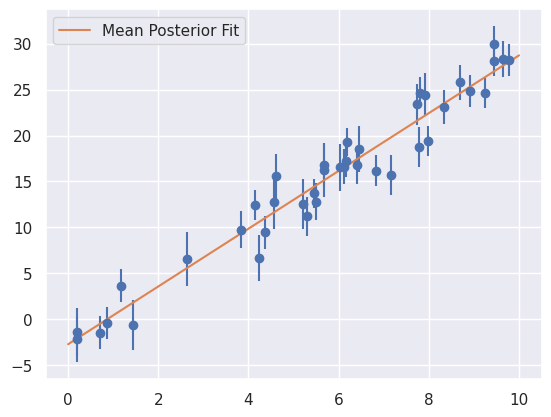

In [10]:
xfit = np.linspace(0, 10)

plt.errorbar(x, y, dy, fmt='o')
plt.plot(xfit, model(theta_MAP, xfit), label='Mean Posterior Fit')
plt.legend(loc='upper left');

Note though that in the Bayesian problem, the result is **not a single number**. The Bayesian result is the full posterior, which our lines have sampled.
One way to examine the results is to plot many lines based on these samples:

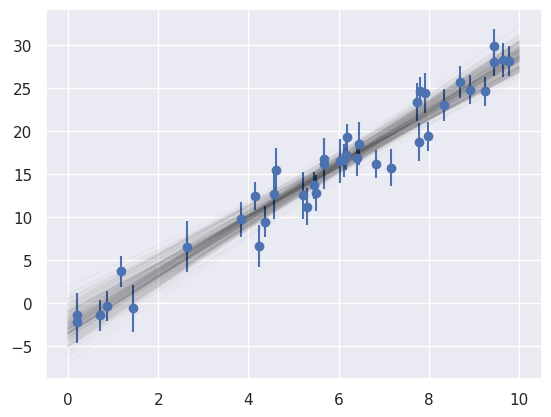

In [11]:
xfit = np.linspace(0, 10)

# Choose 200 random indices
indices = np.random.choice(np.arange(len(sample)), 200)

plt.errorbar(x, y, dy, fmt='o')
for i in indices:
    plt.plot(xfit, model(sample[i], xfit), '-k', alpha=0.02)

This gives us an idea of the spread in the posterior, which is related to the error in the derived parameters.

## MCMC: the Metropolis Hastings Sampler

In the afternoon breakout, we'll explore what is perhaps the simplest sampling algorithm, the Metropolis-Hastings sampler.

This sampler is a procedure which selects a chain of points which (in the long-term limit) will be a representative sample from the posterior. The procedure is surprisingly simple:

1. Define a posterior $p(\theta~|~D, I)$
2. Define a *proposal density* $p(\theta_{i + 1}~|~\theta_i, P)$, which must be a symmetric function, but otherwise is unconstrained (a Gaussian is the usual choice).
3. Choose a starting point $\theta_0$
4. Repeat the following:

   1. Given $\theta_i$, draw a new $\theta_{i + 1}$
   
   2. Compute the *acceptance ratio*
      $$
      a = \frac{p(\theta_{i + 1}~|~D,I)}{p(\theta_i~|~D,I)}
      $$
   
   3. If $a \ge 1$, the proposal is more likely: accept the draw and add $\theta_{i + 1}$ to the chain.
   
   4. If $a < 1$, then accept the point with probability $a$: this can be done by drawing a uniform random number $r$ and checking if $a < r$. If the point is accepted, add $\theta_{i + 1}$ to the chain. If not, then add $\theta_i$ to the chain *again*.
   
During the breakout, you'll have a chance to create this sampler from scratch and use it to solve the straight line fit problem!